# Determining the Temperature of the Alloy

<b>Objective</b>

Develop a regression model that will predict the temperature of steel.

<b>Project Plan</b>

1. Opening data files and reviewing general information
2. Data preprocessing
3. Preparing data for model training
4. Model training
5. Testing the best model and verifying its adequacy
6. Final report

<b>Data Description</b>

The data consists of files sourced from various origins:
- `data_arc_new.csv` — data on electrodes;
- `data_bulk_new.csv` — data on bulk material feed (volume);
- `data_bulk_time_new.csv` — data on bulk material feed (timing);
- `data_gas_new.csv` — data on alloy gas flushing;
- `data_temp_new.csv` — temperature measurement results;
- `data_wire_new.csv` — data on wire materials (volume);
- `data_wire_time_new.csv` — data on wire materials (timing).

All files have a 'key' column indicating the batch number. Some files may have multiple rows with the same 'key' value, corresponding to different processing iterations.

<b>Description of the Processing Stage</b>

Steel is processed in a metallic ladle with a capacity of about 100 tons. To endure high temperatures, its interior is lined with refractory bricks. Molten steel is poured into the ladle and heated to the desired temperature with graphite electrodes, which are mounted on the ladle's lid.

Sulfur is removed from the alloy (desulfurization), the chemical composition is adjusted by adding additives, and samples are taken. Steel is alloyed – its composition is modified – by adding pieces of alloy from a bulk materials hopper or wire through a special tribe apparatus.

Before introducing alloying additives for the first time, the steel's temperature is measured, and its chemical analysis is conducted. The temperature is then raised for a few minutes, alloying materials are added, and the alloy is flushed with inert gas. It is then stirred and measurements are taken again. This cycle continues until the target chemical composition and optimal melting temperature are achieved.

The molten steel is then sent for metal finishing or to a continuous casting machine. The final product emerges as slab billets.

## Exploratory Data Analysis

In [1]:
#!pip install catboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)

In [3]:
# open the database

try:
    data_arc_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')
    data_bulk_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')
    bulk_time_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')
    data_gas_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')
    data_temp_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')
    data_wire_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')
    data_wire_time_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')
except:
    data_arc_new = pd.read_csv('data_arc_new.csv')
    data_bulk_new = pd.read_csv('data_bulk_new')
    bulk_time_new = pd.read_csv('bulk_time_new.csv')
    data_gas_new = pd.read_csv('data_gas_new.csv')
    data_temp_new = pd.read_csv('data_temp_new.csv')
    data_wire_new = pd.read_csv('data_wire_new.csv')
    data_wire_time_new = pd.read_csv('data_wire_time_new.csv')

In [4]:
# function to study the dataset

def info(df):
    print('Information about the dataframe:')
    print(df.info())
    print('First 5 rows:')
    display(df.head())
    print('Last 5 rows:')
    display(df.tail())
    print('Statistical information:')
    display(df.describe())
    print('Number of duplicates:')
    print(df.duplicated().sum())
    print('Number of missing values:')
    print(df.isna().sum())

### data on electrodes

In [5]:
info(data_arc_new)

Information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
First 5 rows:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Last 5 rows:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543
14875,3241,2019-09-06 17:24:54,2019-09-06 17:26:15,0.389057,0.251347


Statistical information:


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


Number of duplicates:
0
Number of missing values:
key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64


In [6]:
print('Unique batches:', data_arc_new['key'].sort_values().nunique())

Unique batches: 3214


In [7]:
grouped = data_arc_new.groupby('key').size()
single_iteration_batches = grouped[grouped == 1].count()
print('Batches with a single processing iteration:', single_iteration_batches)

Batches with a single processing iteration: 39


In [8]:
# check if the data is sorted by time

data_arc_new['Начало нагрева дугой'] = pd.to_datetime(data_arc_new['Начало нагрева дугой'])
is_sorted = data_arc_new['Начало нагрева дугой'].is_monotonic
print('Data is sorted by time:', is_sorted)

Data is sorted by time: True


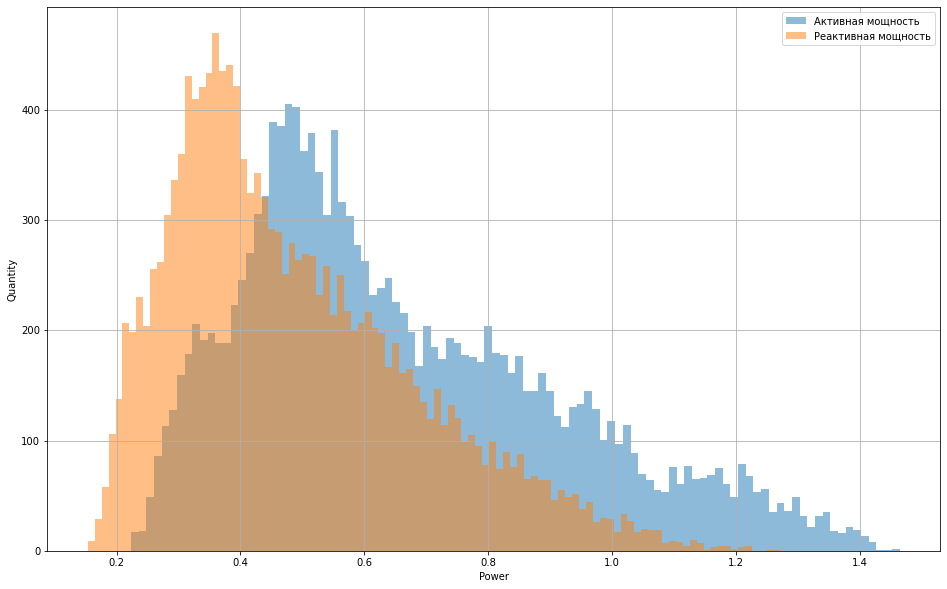

In [9]:
# visualization of powers

data_arc_filtered = data_arc_new[data_arc_new['Реактивная мощность'] > 0]
fig, ax = plt.subplots(figsize=(16,10))
data_arc_filtered['Активная мощность'].hist(bins=100, alpha=0.5, label='Активная мощность')
data_arc_filtered['Реактивная мощность'].hist(bins=100, alpha=0.5, label='Реактивная мощность')
ax.legend()
ax.set_xlabel('Power')
ax.set_ylabel('Quantity')
plt.show()

<b>Conclusion on the dataset:</b>

The table presents data on electrodes. There is one significant anomaly - negative reactive power. We will remove the batch with this iteration. There are no duplicates and no missing values. In the next stage, powers will be aggregated by the average, and total power will also be calculated.

### data on bulk material feed (volume)

In [10]:
info(data_bulk_new)

Information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None
First 5 rows:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Last 5 rows:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


Statistical information:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Number of duplicates:
0
Number of missing values:
key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


In [11]:
print('Unique batches:', data_bulk_new['key'].sort_values().nunique())

Unique batches: 3129


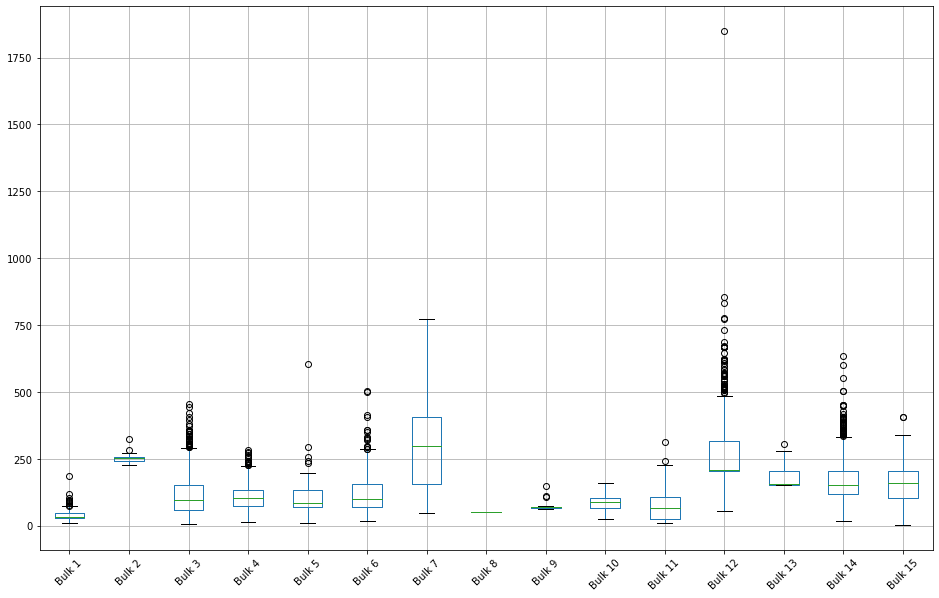

In [12]:
# box and whisker plot for all bulk materials

data_bulk_filtered = data_bulk_new.drop(columns='key')
fig, ax = plt.subplots(figsize=(16,10))
data_bulk_filtered.boxplot(ax=ax)
plt.xticks(rotation=45)
plt.show()

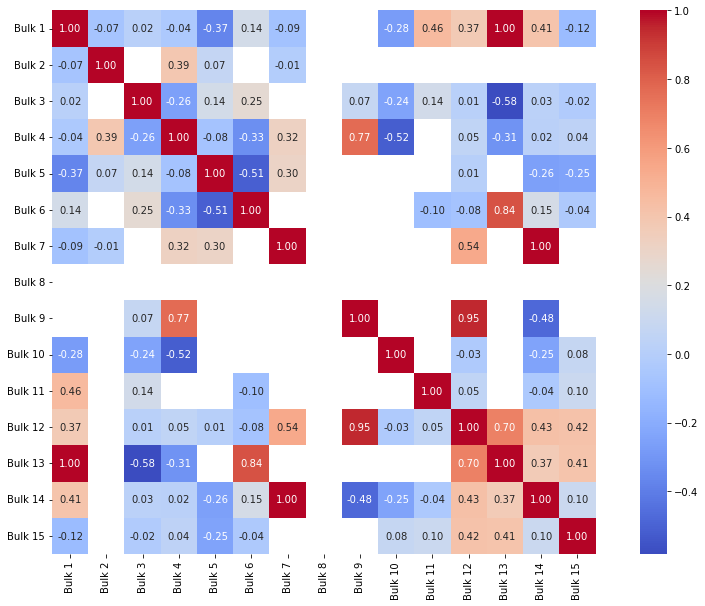

In [13]:
# heatmap of correlation

corr_matrix = data_bulk_filtered.corr()
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.show()

<b>Analysis of the bulk materials dataset</b>

This table presents data on bulk materials. There are a total of 15 materials. Some materials were added a minimal number of times, for example number 8 - only once, numbers 2, 7, 9, and 13 - less than 25 times. We could have removed them, but since the model should operate under real physical conditions, we won't do this. There are no duplicates, and there are also no significant correlations (there are correlations of 0.52-0.77, but at least one parameter involved in such a correlation has an extremely small number of observations). Material number 12 has an extremely large outlier, but we will not remove it.

### data on bulk material feed (timing)

In [14]:
info(bulk_time_new)

Information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None
First 5 rows:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


Last 5 rows:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,2019-09-06 11:54:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 11:49:45,NaN,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,NaN,NaN,2019-09-06 12:26:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 12:18:35,NaN,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:06:00,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:01:44,NaN,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:24:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:07:29,2019-09-06 16:01:34
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 17:26:33,2019-09-06 17:23:15


Statistical information:


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Number of duplicates:
0
Number of missing values:
key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


<b>The dataset on the timing of bulk material feed is not planned to be used in the final dataset</b>

### data on alloy gas flushing

In [15]:
info(data_gas_new)

Information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
First 5 rows:


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Last 5 rows:


,key,Газ 1
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959


Statistical information:


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Number of duplicates:
0
Number of missing values:
key      0
Газ 1    0
dtype: int64


In [16]:
print('Unique batches:', data_gas_new['key'].sort_values().nunique())

Unique batches: 3239


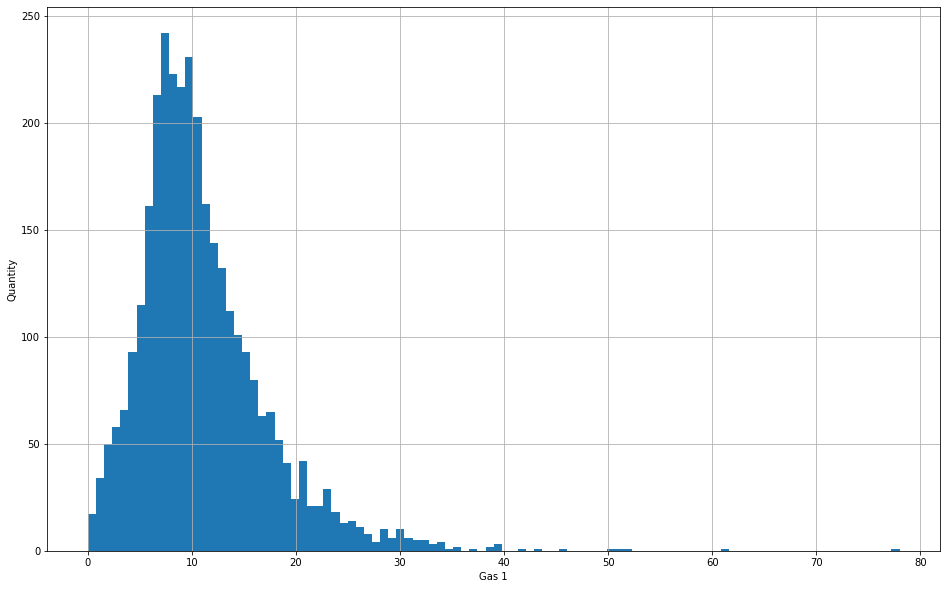

In [17]:
# visualize the feature
fig, ax = plt.subplots(figsize=(16,10))
data_gas_new['Газ 1'].hist(bins=100, ax=ax)
ax.set_xlabel('Gas 1')
ax.set_ylabel('Quantity')
plt.show()

<b>Analysis of the alloy gas blowing dataset</b>

The dataset consists of only one column with the feature "Gas 1". There are no missing values or duplicates. There are outliers that will be retained for the model to operate in real-world conditions.

### temperature measurement results

In [18]:
info(data_temp_new)

Information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
None
First 5 rows:


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Last 5 rows:


,key,Время замера,Температура
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN
18091,3241,2019-09-06 17:30:05,NaN


Statistical information:


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


Number of duplicates:
0
Number of missing values:
key                0
Время замера       0
Температура     3427
dtype: int64


In [19]:
print('Unique batches:', data_temp_new['key'].sort_values().nunique())

Unique batches: 3216


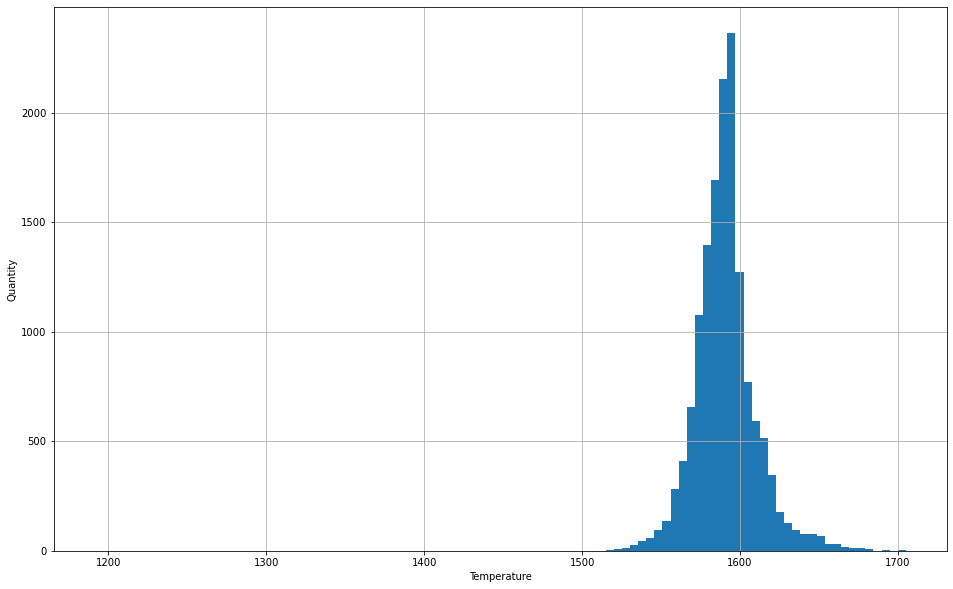

In [20]:
# visualize temperature data

fig, ax = plt.subplots(figsize=(16,10))
data_temp_new['Температура'].hist(bins=100, ax=ax)
ax.set_xlabel('Temperature')
ax.set_ylabel('Quantity')
plt.show()

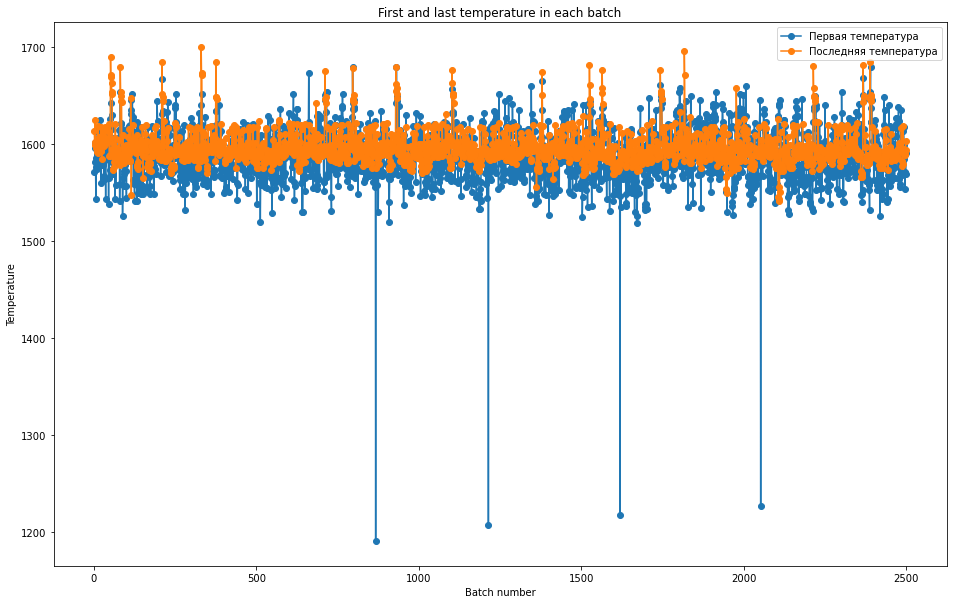

In [21]:
data_temp_new['Время замера'] = pd.to_datetime(data_temp_new['Время замера'])
data_temp_sorted = data_temp_new.sort_values(by=['key', 'Время замера'])
first_temp = data_temp_sorted.groupby('key')['Температура'].first()
last_temp = data_temp_sorted.groupby('key')['Температура'].last()
temp_df = pd.concat([first_temp, last_temp], axis=1)
temp_df.columns = ['Первая температура', 'Последняя температура']
temp_df = temp_df[temp_df['Первая температура'] != temp_df['Последняя температура']]
plt.figure(figsize=(16,10))
plt.plot(temp_df['Первая температура'], label='Первая температура', marker='o')
plt.plot(temp_df['Последняя температура'], label='Последняя температура', marker='o')
plt.legend()
plt.title('First and last temperature in each batch')
plt.xlabel('Batch number')
plt.ylabel('Temperature')
plt.show()

In [22]:
# number of iterations where the temperature is below 1500 degrees
# and how many batches are affected by this issue

num_iterations = (data_temp_new['Температура'] < 1500).sum()
num_batches = data_temp_new[data_temp_new['Температура'] < 1500]['key'].nunique()
print(f'Number of iterations where the temperature is below 1500 degrees: {num_iterations}')
print(f'Number of batches where the temperature is below 1500 degrees: {num_batches}')

Number of iterations where the temperature is below 1500 degrees: 5
Number of batches where the temperature is below 1500 degrees: 5


<b>Analysis of the temperature measurement results dataset</b>

This dataset contains the target feature - the final temperature. There are many missing values, which will be deleted. Also, batches (5 of them) where the temperature (at any stage) is below 1500 degrees will be removed.

### data on wire materials (volume)

In [23]:
info(data_wire_new)

Information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None
First 5 rows:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Last 5 rows:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Statistical information:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Number of duplicates:
0
Number of missing values:
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


In [24]:
print('Unique batches:', data_wire_new['key'].sort_values().nunique())

Unique batches: 3081


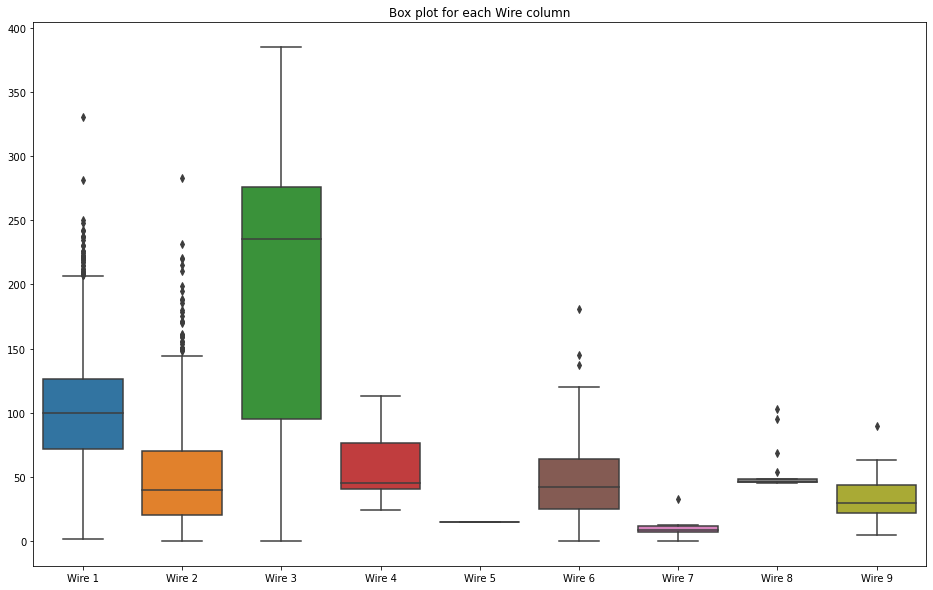

In [25]:
# box plot for wire materials

plt.figure(figsize=(16,10))
sns.boxplot(data=data_wire_new.drop(columns='key'))
plt.title('Box plot for each Wire column')
plt.show()

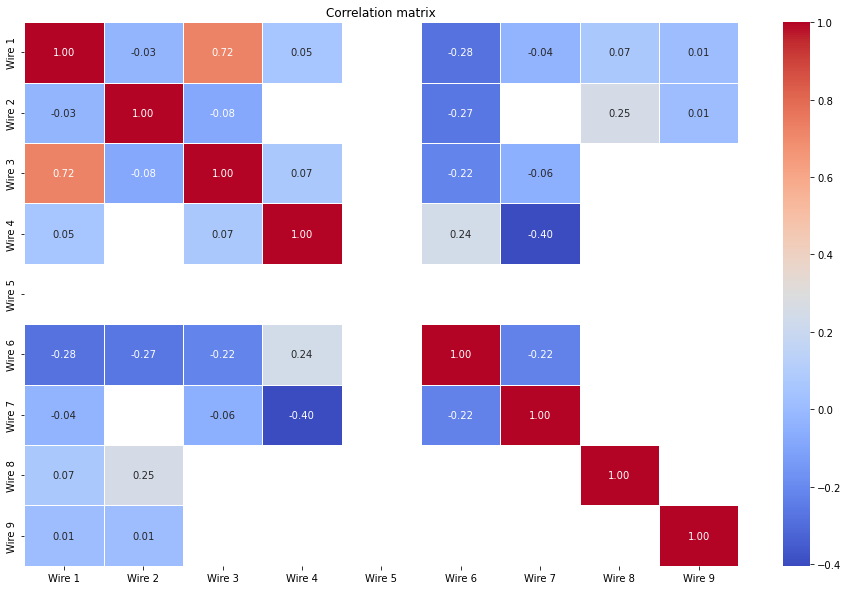

In [26]:
# and a correlation matrix

corr = data_wire_new.drop(columns='key').corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr, annot=True, fmt=".2f", linewidths=.5, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

<b>Analysis of the wire materials dataset</b>

It's evident that out of 9 materials, the first two are used the most. The rest were added less than 100 times, and material 5 was added only once. There's a strong positive correlation between materials 1 and 3.

### data on wire materials (timing)

In [27]:
info(data_wire_time_new)

Information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None
First 5 rows:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Last 5 rows:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,2019-09-06 11:33:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-09-06 12:18:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-06 14:36:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-06 15:33:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,2019-09-06 17:10:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Statistical information:


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Number of duplicates:
0
Number of missing values:
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


<b>The dataset about wire materials by time is not planned to be used in the final dataset</b>

# Future Work Plan

We have analyzed the provided data.

The next steps are:

<b>1. Data preprocessing:</b>
- Remove the anomalous batch where there is a negative reactive power in one of the iterations;
- Aggregate power by the key, select the average value;
- Following the client's instructions, we will delete batches where the temperature dropped below 1500 degrees;
- Delete all intermediate iterations in batches (only leave the first and last temperature);
- Delete batches where there is only one temperature iteration;
- Some datasets have some unusual data (like gas 77.995), but we will try not to delete them to maximize model authenticity;
- We won't preprocess the temporal tables (bulk and wire materials) since they won't be in the final dataset;
- After preprocessing, merge into a single table by key (only merge with keys present in all used tables);
- Convert column names in the final table to lowercase Latin letters, check data type accuracy.

<b>2. Preparing data for training:</b>
- Probable features will be: 
    - Aggregated active power, reactive power, total power
    - All bulk materials
    - All wire materials
    - Gas
    - Initial temperature
- Target feature - final temperature.
- Check data for multicollinearity.
- No validation set, test set will be 25%.


<b>3. Training:</b>
- At least 2 models will be used:
    - Random Forest	
    - Cat Boost
- Depending on the notebook's runtime (task is 30-60 minutes), additional models might be added (like Linear Regression and LGBM).
- Quality metric - MAE, goal is less than 6.8.
- Testing the best model
- Compare with a constant model

<b>4. Writing the final report</b>

## Data preprocessing

In [28]:
# remove batches where the reactive power has negative values

negative_powers = data_arc_new[data_arc_new['Реактивная мощность'] < 0]['key'].unique()
data_arc_good = data_arc_new[~data_arc_new['key'].isin(negative_powers)]

In [29]:
# add a "Heating Duration" column so that later we can aggregate by sum 
# (i.e. calculate the heating time of one batch) to, in turn, calculate work.

# calculate the duration of each iteration
data_arc_good['Конец нагрева дугой'] = pd.to_datetime(data_arc_good['Конец нагрева дугой'])
data_arc_good['Начало нагрева дугой'] = pd.to_datetime(data_arc_good['Начало нагрева дугой'])
data_arc_good['Продолжительность нагрева'] = (data_arc_good['Конец нагрева дугой'] - 
                                              data_arc_good['Начало нагрева дугой']).dt.total_seconds() / 60
data_arc_good

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Продолжительность нагрева
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,3.800000
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,3.083333
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,2.866667
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,6.083333
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,2.466667
...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,2.616667
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,3.000000
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,3.066667
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,0.950000


In [30]:
# aggregate the columns

data_arc_good = data_arc_good.groupby('key').agg({'Активная мощность': 'mean',
                                                 'Реактивная мощность': 'mean',
                                                 'Продолжительность нагрева': 'sum'})
data_arc_good

,Активная мощность,Реактивная мощность,Продолжительность нагрева
key,,,
1,0.607346,0.428564,18.300000
2,0.534852,0.363339,13.516667
3,0.812728,0.587491,10.916667
4,0.676622,0.514248,12.350000
5,0.563238,0.421998,14.483333
...,...,...,...
3237,0.508374,0.405083,15.150000
3238,0.458274,0.346034,9.100000
3239,0.606001,0.442693,20.266667


In [31]:
# calculate the total power. The total power is a geometrically calculated magnitude, 
# equal to the root of the sum of the squares of active and reactive powers
full_power = (data_arc_good['Активная мощность']**2 + data_arc_good['Реактивная мощность']**2) ** 0.5
data_arc_good.insert(2, 'Полная мощность', full_power)
data_arc_good

,Активная мощность,Реактивная мощность,Полная мощность,Продолжительность нагрева
key,,,,
1,0.607346,0.428564,0.743328,18.300000
2,0.534852,0.363339,0.646593,13.516667
3,0.812728,0.587491,1.002833,10.916667
4,0.676622,0.514248,0.849864,12.350000
5,0.563238,0.421998,0.703789,14.483333
...,...,...,...,...
3237,0.508374,0.405083,0.650029,15.150000
3238,0.458274,0.346034,0.574243,9.100000
3239,0.606001,0.442693,0.750476,20.266667


In [32]:
# calculate work - it's the product of total power and heating duration.

data_arc_good['Работа'] = data_arc_good['Полная мощность'] * data_arc_good['Продолжительность нагрева']
data_arc_good.describe()

,Активная мощность,Реактивная мощность,Полная мощность,Продолжительность нагрева,Работа
count,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000
mean,0.661332,0.485966,0.820930,13.244859,10.904880
std,0.128392,0.097600,0.160020,5.540652,5.060490
min,0.267676,0.196228,0.331897,0.950000,0.557170
25%,0.573010,0.417393,0.710263,9.516667,7.518240
50%,0.652864,0.481626,0.812009,12.833333,10.398556
75%,0.739401,0.543327,0.916288,16.383333,13.822151
max,1.243889,0.960763,1.571727,69.816667,71.083873


The table is ready for merging.

In [33]:
# now, we'll immediately fill in the missing values 
# in the datasets data_bulk_new and data_wire_new with zeros.

data_bulk_good = data_bulk_new.fillna(0)
data_bulk_good.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [34]:
# data_wire_new

data_wire_good = data_wire_new.fillna(0)
data_wire_good.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The tables are ready for merging

In [35]:
# we start working with the data_temp_new table: 
# first, we'll remove all batches where the number of iterations is equal to 1

counts = data_temp_new['key'].value_counts()
data_temp_good = data_temp_new[data_temp_new['key'].isin(counts[counts > 1].index)]

In [36]:
# now, we'll only save the first and last iteration of temperature measurement.

data_temp_good = data_temp_good.sort_values(['key', 'Время замера'])
data_temp_good = data_temp_good.groupby('key').apply(lambda x: pd.concat([x.head(1), x.tail(1)]) if len(x) > 2 else x)
data_temp_good = data_temp_good.reset_index(drop=True)
data_temp_good

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:30:38,1613.0
2,2,2019-05-03 11:34:04,1581.0
3,2,2019-05-03 11:55:09,1602.0
4,3,2019-05-03 12:06:44,1596.0
...,...,...,...
6423,3239,2019-09-06 15:09:55,NaN
6424,3240,2019-09-06 15:25:21,1617.0
6425,3240,2019-09-06 16:35:26,NaN
6426,3241,2019-09-06 16:48:55,1586.0


In [37]:
# remove batches where either the first or last temperature has at least one NaN value

nan_keys = data_temp_good[data_temp_good.isna().any(axis=1)]['key'].unique()
data_temp_good = data_temp_good[~data_temp_good['key'].isin(nan_keys)]
data_temp_good

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:30:38,1613.0
2,2,2019-05-03 11:34:04,1581.0
3,2,2019-05-03 11:55:09,1602.0
4,3,2019-05-03 12:06:44,1596.0
...,...,...,...
4945,2497,2019-08-10 12:53:28,1589.0
4946,2498,2019-08-10 12:58:11,1591.0
4947,2498,2019-08-10 13:23:31,1594.0
4948,2499,2019-08-10 13:33:21,1569.0


In [38]:
# create separate columns with the first and final temperatures

data_temp_good = data_temp_good.groupby('key')['Температура'].agg(['first', 'last']).reset_index()
data_temp_good.columns = ['key', 'Первая температура', 'Финальная температура']
data_temp_good

,key,Первая температура,Финальная температура
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2470,2495,1570.0,1591.0
2471,2496,1554.0,1591.0
2472,2497,1571.0,1589.0
2473,2498,1591.0,1594.0


The table is ready for merging. The gas table does not require preprocessing, we won't add the time tables.

In [39]:
# merge tables by key

data_final = data_arc_good.merge(data_bulk_good, on='key', how='inner')
data_final = data_final.merge(data_wire_good, on='key', how='inner')
data_final = data_final.merge(data_gas_new, on='key', how='inner')
data_final = data_final.merge(data_temp_good, on='key', how='inner')

In [40]:
# standardize the columns to a common format

column_mapping = {
    'key': 'key',
    'Активная мощность': 'active_power',
    'Реактивная мощность': 'reactive_power',
    'Полная мощность': 'full_power',
    'Продолжительность нагрева': 'heating_duration',
    'Работа': 'work',
    'Bulk 1': 'bulk_1',
    'Bulk 2': 'bulk_2',
    'Bulk 3': 'bulk_3',
    'Bulk 4': 'bulk_4',
    'Bulk 5': 'bulk_5',
    'Bulk 6': 'bulk_6',
    'Bulk 7': 'bulk_7',
    'Bulk 8': 'bulk_8',
    'Bulk 9': 'bulk_9',
    'Bulk 10': 'bulk_10',
    'Bulk 11': 'bulk_11',
    'Bulk 12': 'bulk_12',
    'Bulk 13': 'bulk_13',
    'Bulk 14': 'bulk_14',
    'Bulk 15': 'bulk_15',
    'Wire 1': 'wire_1',
    'Wire 2': 'wire_2',
    'Wire 3': 'wire_3',
    'Wire 4': 'wire_4',
    'Wire 5': 'wire_5',
    'Wire 6': 'wire_6',
    'Wire 7': 'wire_7',
    'Wire 8': 'wire_8',
    'Wire 9': 'wire_9',
    'Газ 1': 'gas_1',
    'Первая температура': 'first_temperature',
    'Финальная температура': 'final_temperature',
}

data_final = data_final.rename(columns=column_mapping)

In [41]:
# information about the final dataset

info(data_final)

Information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 0 to 2327
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2328 non-null   int64  
 1   active_power       2328 non-null   float64
 2   reactive_power     2328 non-null   float64
 3   full_power         2328 non-null   float64
 4   heating_duration   2328 non-null   float64
 5   work               2328 non-null   float64
 6   bulk_1             2328 non-null   float64
 7   bulk_2             2328 non-null   float64
 8   bulk_3             2328 non-null   float64
 9   bulk_4             2328 non-null   float64
 10  bulk_5             2328 non-null   float64
 11  bulk_6             2328 non-null   float64
 12  bulk_7             2328 non-null   float64
 13  bulk_8             2328 non-null   float64
 14  bulk_9             2328 non-null   float64
 15  bulk_10            2328 non-null   floa

,key,active_power,reactive_power,full_power,heating_duration,work,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas_1,first_temperature,final_temperature
0,1,0.607346,0.428564,0.743328,18.300000,13.602901,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,1571.0,1613.0
1,2,0.534852,0.363339,0.646593,13.516667,8.739778,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,1581.0,1602.0
2,3,0.812728,0.587491,1.002833,10.916667,10.947589,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,1596.0,1599.0
3,4,0.676622,0.514248,0.849864,12.350000,10.495819,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,1601.0,1625.0
4,5,0.563238,0.421998,0.703789,14.483333,10.193207,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,1576.0,1602.0


Last 5 rows:


,key,active_power,reactive_power,full_power,heating_duration,work,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas_1,first_temperature,final_temperature
2323,2495,0.792033,0.552734,0.965832,12.050000,11.638276,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.125735,1570.0,1591.0
2324,2496,0.695820,0.478672,0.844566,15.666667,13.231534,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.412616,1554.0,1591.0
2325,2497,1.201746,0.817364,1.453368,9.483333,13.782772,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.271699,1571.0,1589.0
2326,2498,0.640462,0.447964,0.781577,12.500000,9.769718,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.953657,1591.0,1594.0
2327,2499,0.434271,0.324209,0.541944,14.716667,7.975602,0.0,0.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,233.0,0.0,126.0,227.0,110.160958,50.00528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.336151,1569.0,1603.0


Statistical information:


,key,active_power,reactive_power,full_power,heating_duration,work,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas_1,first_temperature,final_temperature
count,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.0,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000
mean,1251.461340,0.664104,0.488890,0.824897,13.463474,11.149235,3.429124,1.423110,47.368557,37.319588,2.641323,22.381014,2.005584,0.021048,0.445017,5.054983,4.246993,208.505155,1.067869,153.834622,120.004296,102.455296,17.617423,3.236305,0.306682,0.0,0.979240,0.006363,0.311445,0.317249,11.375511,1586.722079,1593.371993
std,714.691385,0.128377,0.097967,0.160222,5.680385,5.243049,12.414595,19.086196,75.320213,58.650737,22.407040,55.752272,30.682797,1.015558,6.221971,20.922031,22.520153,157.036569,14.238096,81.416698,84.622085,43.545688,33.630013,27.948793,4.758764,0.0,8.695143,0.205749,4.403648,3.457298,6.393413,28.296417,11.198791
min,1.000000,0.267676,0.196228,0.331897,0.950000,0.557170,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.008399,1191.000000,1541.000000
25%,629.750000,0.576159,0.420039,0.713700,9.683333,7.699090,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000,73.204559,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,7.282534,1571.000000,1587.000000
50%,1254.500000,0.655834,0.484669,0.817634,12.966667,10.501275,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000,101.119202,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,10.100687,1587.000000,1593.000000
75%,1867.250000,0.741641,0.546539,0.920524,16.550000,13.998861,0.000000,0.000000,80.000000,77.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.250000,0.000000,204.000000,204.000000,128.097058,23.110100,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,14.216939,1603.000000,1598.000000
max,2499.000000,1.243889,0.960763,1.571727,69.816667,71.083873,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600,77.995040,1660.000000,1653.000000


Number of duplicates:
0
Number of missing values:
key                  0
active_power         0
reactive_power       0
full_power           0
heating_duration     0
work                 0
bulk_1               0
bulk_2               0
bulk_3               0
bulk_4               0
bulk_5               0
bulk_6               0
bulk_7               0
bulk_8               0
bulk_9               0
bulk_10              0
bulk_11              0
bulk_12              0
bulk_13              0
bulk_14              0
bulk_15              0
wire_1               0
wire_2               0
wire_3               0
wire_4               0
wire_5               0
wire_6               0
wire_7               0
wire_8               0
wire_9               0
gas_1                0
first_temperature    0
final_temperature    0
dtype: int64


In [42]:
# now we'll analyze the gas anomalies - clear anomalies after a value of 40, 
# compare them with the rest of the dataset and replace 0 with NaN, so zeros don't affect the statistics

gas_anomaly = data_final.query('gas_1 >= 40')
gas_anomaly = gas_anomaly.replace(0, np.nan)
gas_anomaly.describe()

,key,active_power,reactive_power,full_power,heating_duration,work,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas_1,first_temperature,final_temperature
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,6.000000,3.000000,3.00000,6.000000,3.000000,0.0,3.000000,0.0,1.0,0.0,0.0,4.000000,0.0,4.000000,2.000000,5.000000,2.000000,3.000000,2.000000,0.0,3.000000,2.000000,1.000000,0.0,7.000000,7.000000,7.000000
mean,1009.142857,0.550789,0.394531,0.677571,27.154762,19.498403,66.166667,279.000000,109.00000,91.666667,109.333333,NaN,439.333333,NaN,63.0,NaN,NaN,786.000000,NaN,376.000000,152.000000,117.111698,132.232358,93.149060,74.324641,NaN,60.483285,0.644072,46.002319,NaN,53.257598,1602.857143,1588.142857
std,870.422968,0.134736,0.092485,0.163143,14.209369,13.192831,59.734133,42.225585,14.73092,25.160816,14.189198,NaN,58.603185,NaN,NaN,NaN,NaN,759.149963,NaN,174.354046,73.539105,115.248971,79.190574,0.073398,25.803402,NaN,32.302804,0.579635,NaN,NaN,12.646305,41.305482,31.077476
min,117.000000,0.389026,0.289273,0.484789,9.116667,4.419661,27.000000,242.000000,100.00000,58.000000,94.000000,NaN,405.000000,NaN,63.0,NaN,NaN,108.000000,NaN,263.000000,100.000000,3.101280,76.236166,93.068977,56.078880,NaN,26.975523,0.234208,46.002319,NaN,41.854643,1532.000000,1541.000000
25%,301.000000,0.436628,0.314339,0.538071,16.675000,10.687109,33.000000,256.000000,100.50000,74.500000,103.000000,NaN,405.500000,NaN,63.0,NaN,NaN,336.750000,NaN,290.000000,126.000000,11.051040,104.234262,93.117027,65.201760,NaN,45.010684,0.439140,46.002319,NaN,44.647205,1580.000000,1568.000000
50%,663.000000,0.539777,0.379799,0.660005,27.550000,17.342020,45.500000,270.000000,101.00000,96.000000,112.000000,NaN,406.000000,NaN,63.0,NaN,NaN,593.500000,NaN,302.500000,152.000000,130.244400,132.232358,93.165077,74.324641,NaN,63.045845,0.644072,46.002319,NaN,50.581035,1619.000000,1600.000000
75%,1786.000000,0.677465,0.479518,0.835231,37.208333,27.813589,60.250000,297.500000,113.50000,103.250000,117.000000,NaN,456.500000,NaN,63.0,NaN,NaN,1042.750000,NaN,388.500000,178.000000,160.174557,160.230454,93.189102,83.447521,NaN,77.237166,0.849004,46.002319,NaN,56.539031,1632.000000,1610.000000
max,2110.000000,0.698533,0.504934,0.851597,45.650000,37.725746,185.000000,325.000000,126.00000,127.000000,122.000000,NaN,507.000000,NaN,63.0,NaN,NaN,1849.000000,NaN,636.000000,204.000000,280.987214,188.228550,93.213127,92.570401,NaN,91.428487,1.053936,46.002319,NaN,77.995040,1645.000000,1620.000000


In [43]:
data_final_normal_gas = data_final.query('gas_1 < 40')
data_final_normal_gas_nan = data_final_normal_gas.replace(0, np.nan)
data_final_normal_gas_nan.describe()

,key,active_power,reactive_power,full_power,heating_duration,work,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas_1,first_temperature,final_temperature
count,2321.000000,2321.000000,2321.000000,2321.000000,2321.000000,2321.000000,193.000000,10.000000,957.000000,806.000000,50.000000,437.000000,10.000000,1.0,12.000000,143.000000,130.000000,1808.000000,14.000000,2063.000000,1697.000000,2300.000000,809.000000,36.000000,10.000000,0.0,42.000000,2.000000,12.000000,24.000000,2321.000000,2321.000000,2321.000000
mean,1252.192159,0.664446,0.489175,0.825341,13.422182,11.124055,39.305699,247.600000,114.887147,107.109181,116.420000,119.228833,335.100000,49.0,81.083333,82.293706,76.053846,266.734513,177.571429,172.866214,164.446671,103.447987,50.369465,201.518661,56.530554,NaN,49.957666,6.762756,56.586748,30.773167,11.249197,1586.673417,1593.387764
std,714.274337,0.128237,0.097864,0.160044,5.592376,5.187621,15.092590,15.826841,77.603554,49.175518,98.003142,70.823937,233.630977,NaN,26.428147,27.788900,60.373554,119.394614,50.344527,63.109288,50.034878,42.305345,39.498606,100.584292,32.049704,NaN,38.344548,2.442748,20.911800,15.210141,5.939437,28.247173,11.100035
min,1.000000,0.267676,0.196228,0.331897,0.950000,0.557170,10.000000,228.000000,6.000000,13.000000,11.000000,17.000000,75.000000,49.0,65.000000,24.000000,8.000000,53.000000,151.000000,29.000000,1.000000,1.918800,0.030160,0.144144,24.148801,NaN,0.137280,5.035472,45.076721,4.622800,0.008399,1191.000000,1543.000000
25%,631.000000,0.576799,0.420259,0.713916,9.683333,7.695816,27.000000,235.250000,57.000000,73.000000,63.250000,72.000000,160.750000,49.0,66.000000,58.000000,25.000000,204.000000,153.250000,123.000000,105.000000,75.042236,20.180161,95.279186,34.903963,NaN,25.053600,5.899114,45.909759,20.802601,7.268466,1571.000000,1587.000000
50%,1255.000000,0.656027,0.484808,0.817669,12.950000,10.496114,31.000000,247.500000,96.000000,105.000000,84.500000,100.000000,279.000000,49.0,69.000000,85.000000,60.000000,208.000000,154.500000,153.000000,200.000000,102.053638,40.082642,242.354126,43.154802,NaN,40.068601,6.762756,46.187439,30.066399,10.087175,1587.000000,1593.000000
75%,1867.000000,0.741925,0.546712,0.920765,16.533333,13.992960,46.000000,255.000000,153.000000,137.000000,148.000000,156.000000,512.750000,49.0,80.250000,104.000000,105.500000,359.000000,158.500000,208.000000,205.000000,128.164142,69.217202,277.333076,76.124619,NaN,64.830481,7.626398,51.833600,40.495001,14.159305,1603.000000,1598.000000
max,2499.000000,1.243889,0.960763,1.571727,69.816667,71.083873,94.000000,282.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,853.000000,305.000000,450.000000,405.000000,330.314424,282.780152,385.008668,113.231044,NaN,180.454575,8.490040,102.762401,62.025600,39.728826,1660.000000,1653.000000


There isn't much difference in powers, yet the heating duration was significantly longer. In addition, almost all medians of bulk materials and wire materials are higher in the cases of "anomalous" gas. Perhaps these gas values are so large because large amounts of bulk materials or wire were used.

<b>Conclusions</b>

We conducted data preprocessing::

- In the power table, the batch with negative reactive power was removed, powers were aggregated by the average value, added values of total power, heating time of each batch, and work. These parameters will be used as features for model training.
- In the temperature table, all values of intermediate temperatures between the first and final temperature values were removed, batches were deleted where there is only one temperature measurement, and those batches where the first or final temperature is unknown.
- Missing values in tables with information on bulk materials and wire materials were replaced with 0.
- A final table was created, combining features for model training and the target feature - final_temperature.

We move on to preparing features for model training.

## Data preparation for model training

In [44]:
# calculate the VIF for each feature

variables = data_final.drop(['key', 'final_temperature'], axis=1)
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
print(vif.sort_values(by='VIF', ascending=False))

             VIF           Features
2   5.188753e+06         full_power
0   2.173300e+06       active_power
1   6.488846e+05     reactive_power
4   1.922387e+02               work
3   1.914401e+02   heating_duration
30  1.566933e+02  first_temperature
13  6.780944e+01             bulk_9
27  5.724491e+01             wire_8
20  8.746479e+00             wire_1
18  7.887754e+00            bulk_14
16  7.417266e+00            bulk_12
29  5.933014e+00              gas_1
19  5.384529e+00            bulk_15
12  3.727465e+00             bulk_8
23  3.470343e+00             wire_4
6   2.877478e+00             bulk_2
11  2.710962e+00             bulk_7
8   2.002439e+00             bulk_4
26  1.626179e+00             wire_7
7   1.620843e+00             bulk_3
21  1.553157e+00             wire_2
25  1.532835e+00             wire_6
10  1.516453e+00             bulk_6
5   1.481890e+00             bulk_1
9   1.182685e+00             bulk_5
22  1.144521e+00             wire_3
14  1.137429e+00            

There's very strong multicollinearity due to the "generated" variables. I think we should remove their constituents. Let's see how this will affect the model, but in this case, we have directly related features, which isn't very good.

In [45]:
data_final = data_final.drop(['active_power', 'reactive_power', 'heating_duration'], axis=1)

In [46]:
# recalculate the VIF

variables = data_final.drop(['key', 'final_temperature'], axis=1)
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
print(vif.sort_values(by='VIF', ascending=False))

          VIF           Features
10  67.748032             bulk_9
24  57.201454             wire_8
27  42.639383  first_temperature
0   36.484263         full_power
1   11.263848               work
17   8.735412             wire_1
15   7.827705            bulk_14
13   7.371828            bulk_12
26   5.907430              gas_1
16   5.367425            bulk_15
9    3.725199             bulk_8
20   3.469871             wire_4
3    2.874242             bulk_2
8    2.710325             bulk_7
5    1.998319             bulk_4
23   1.623764             wire_7
4    1.616008             bulk_3
18   1.551787             wire_2
22   1.531739             wire_6
7    1.515254             bulk_6
2    1.471915             bulk_1
6    1.181903             bulk_5
19   1.142280             wire_3
11   1.135053            bulk_10
12   1.102012            bulk_11
25   1.070178             wire_9
14   1.067121            bulk_13
21        NaN             wire_5


There are still 10 features with a VIF above 5, however, further removal might negatively impact the model

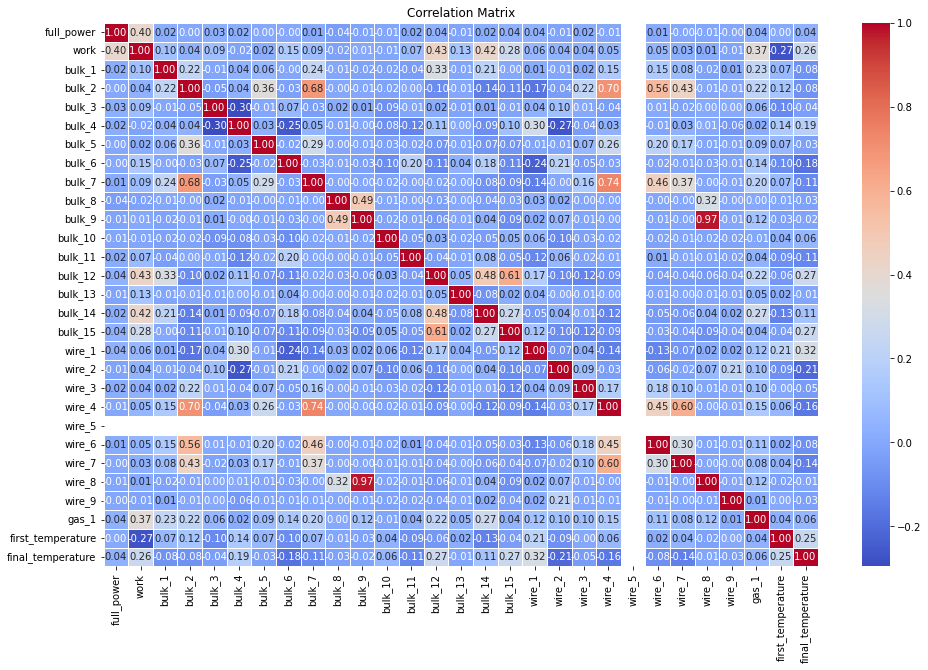

In [47]:
# to make a final decision on which features to keep, we'll build a correlation matrix
corr_final = data_final.drop(columns='key').corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_final, annot=True, fmt=".2f", linewidths=.5, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

There are quite strong correlations, but there is an extremely strong one between wire_8 and bulk_9. Both parameters were added 19 times. However, since both elements are involved in the chemical process, in order for the model to work under real physical conditions, we will not remove either of the parameters. We will still remove the wire_5 feature, which is essentially not involved in the process. Also, we will finally remove the key column, as we won't need it anymore.

In [48]:
data_final = data_final.drop(['key', 'wire_5'], axis=1)

In [49]:
# for interest's sake, let's see how the VIF has changed

variables = data_final.drop(['final_temperature'], axis=1)
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
print(vif.sort_values(by='VIF', ascending=False))

          VIF           Features
10  67.748032             bulk_9
23  57.201454             wire_8
26  42.639383  first_temperature
0   36.484263         full_power
1   11.263848               work
17   8.735412             wire_1
15   7.827705            bulk_14
13   7.371828            bulk_12
25   5.907430              gas_1
16   5.367425            bulk_15
9    3.725199             bulk_8
20   3.469871             wire_4
3    2.874242             bulk_2
8    2.710325             bulk_7
5    1.998319             bulk_4
22   1.623764             wire_7
4    1.616008             bulk_3
18   1.551787             wire_2
21   1.531739             wire_6
7    1.515254             bulk_6
2    1.471915             bulk_1
6    1.181903             bulk_5
19   1.142280             wire_3
11   1.135053            bulk_10
12   1.102012            bulk_11
24   1.070178             wire_9
14   1.067121            bulk_13


Significantly better. Moving forward.

In [50]:
# create features and the target feature, dividing the data into training and testing sets.
x = data_final.drop('final_temperature', axis=1)
y = data_final['final_temperature']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=60623)

In [51]:
# considering that the features are of different scales, scaling is required

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

<b>Conclusions:</b>

Work has been carried out to minimize the effect of multicollinearity - indicators with the maximum VIF have been removed, the bulk_9 indicator was removed due to an extremely strong positive correlation with the wire_8 indicator. The dataset has been divided into features for model training and the target feature. Scaling has been conducted. The features are prepared for model training.

## Modeling

### Decision Tree

In [52]:
# setting up the model
tree = DecisionTreeRegressor(random_state=60623)
tree_params = {'max_depth': range(1,11), 'min_samples_leaf': range(1,11)}
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
tree_grid = GridSearchCV(tree, tree_params, scoring=mae_scorer, cv=5, n_jobs=-1)

# training the model
tree_grid.fit(x_train, y_train)

# predicting on training data
tree_train_predictions = tree_grid.predict(x_train)

# MAE
tree_train_mae = mean_absolute_error(y_train, tree_train_predictions)
print('MAE of the Decision Tree model on the training set:', tree_train_mae)

# Displaying the best score
print('MAE of the Decision Tree model on cross-validation:', -tree_grid.best_score_)

# Displaying the best model parameters
print('Parameters of the best Decision Tree model:', tree_grid.best_params_)

MAE of the Decision Tree model on the training set: 6.19989139073108
MAE of the Decision Tree model on cross-validation: 7.406757211630556
Parameters of the best Decision Tree model: {'max_depth': 6, 'min_samples_leaf': 4}


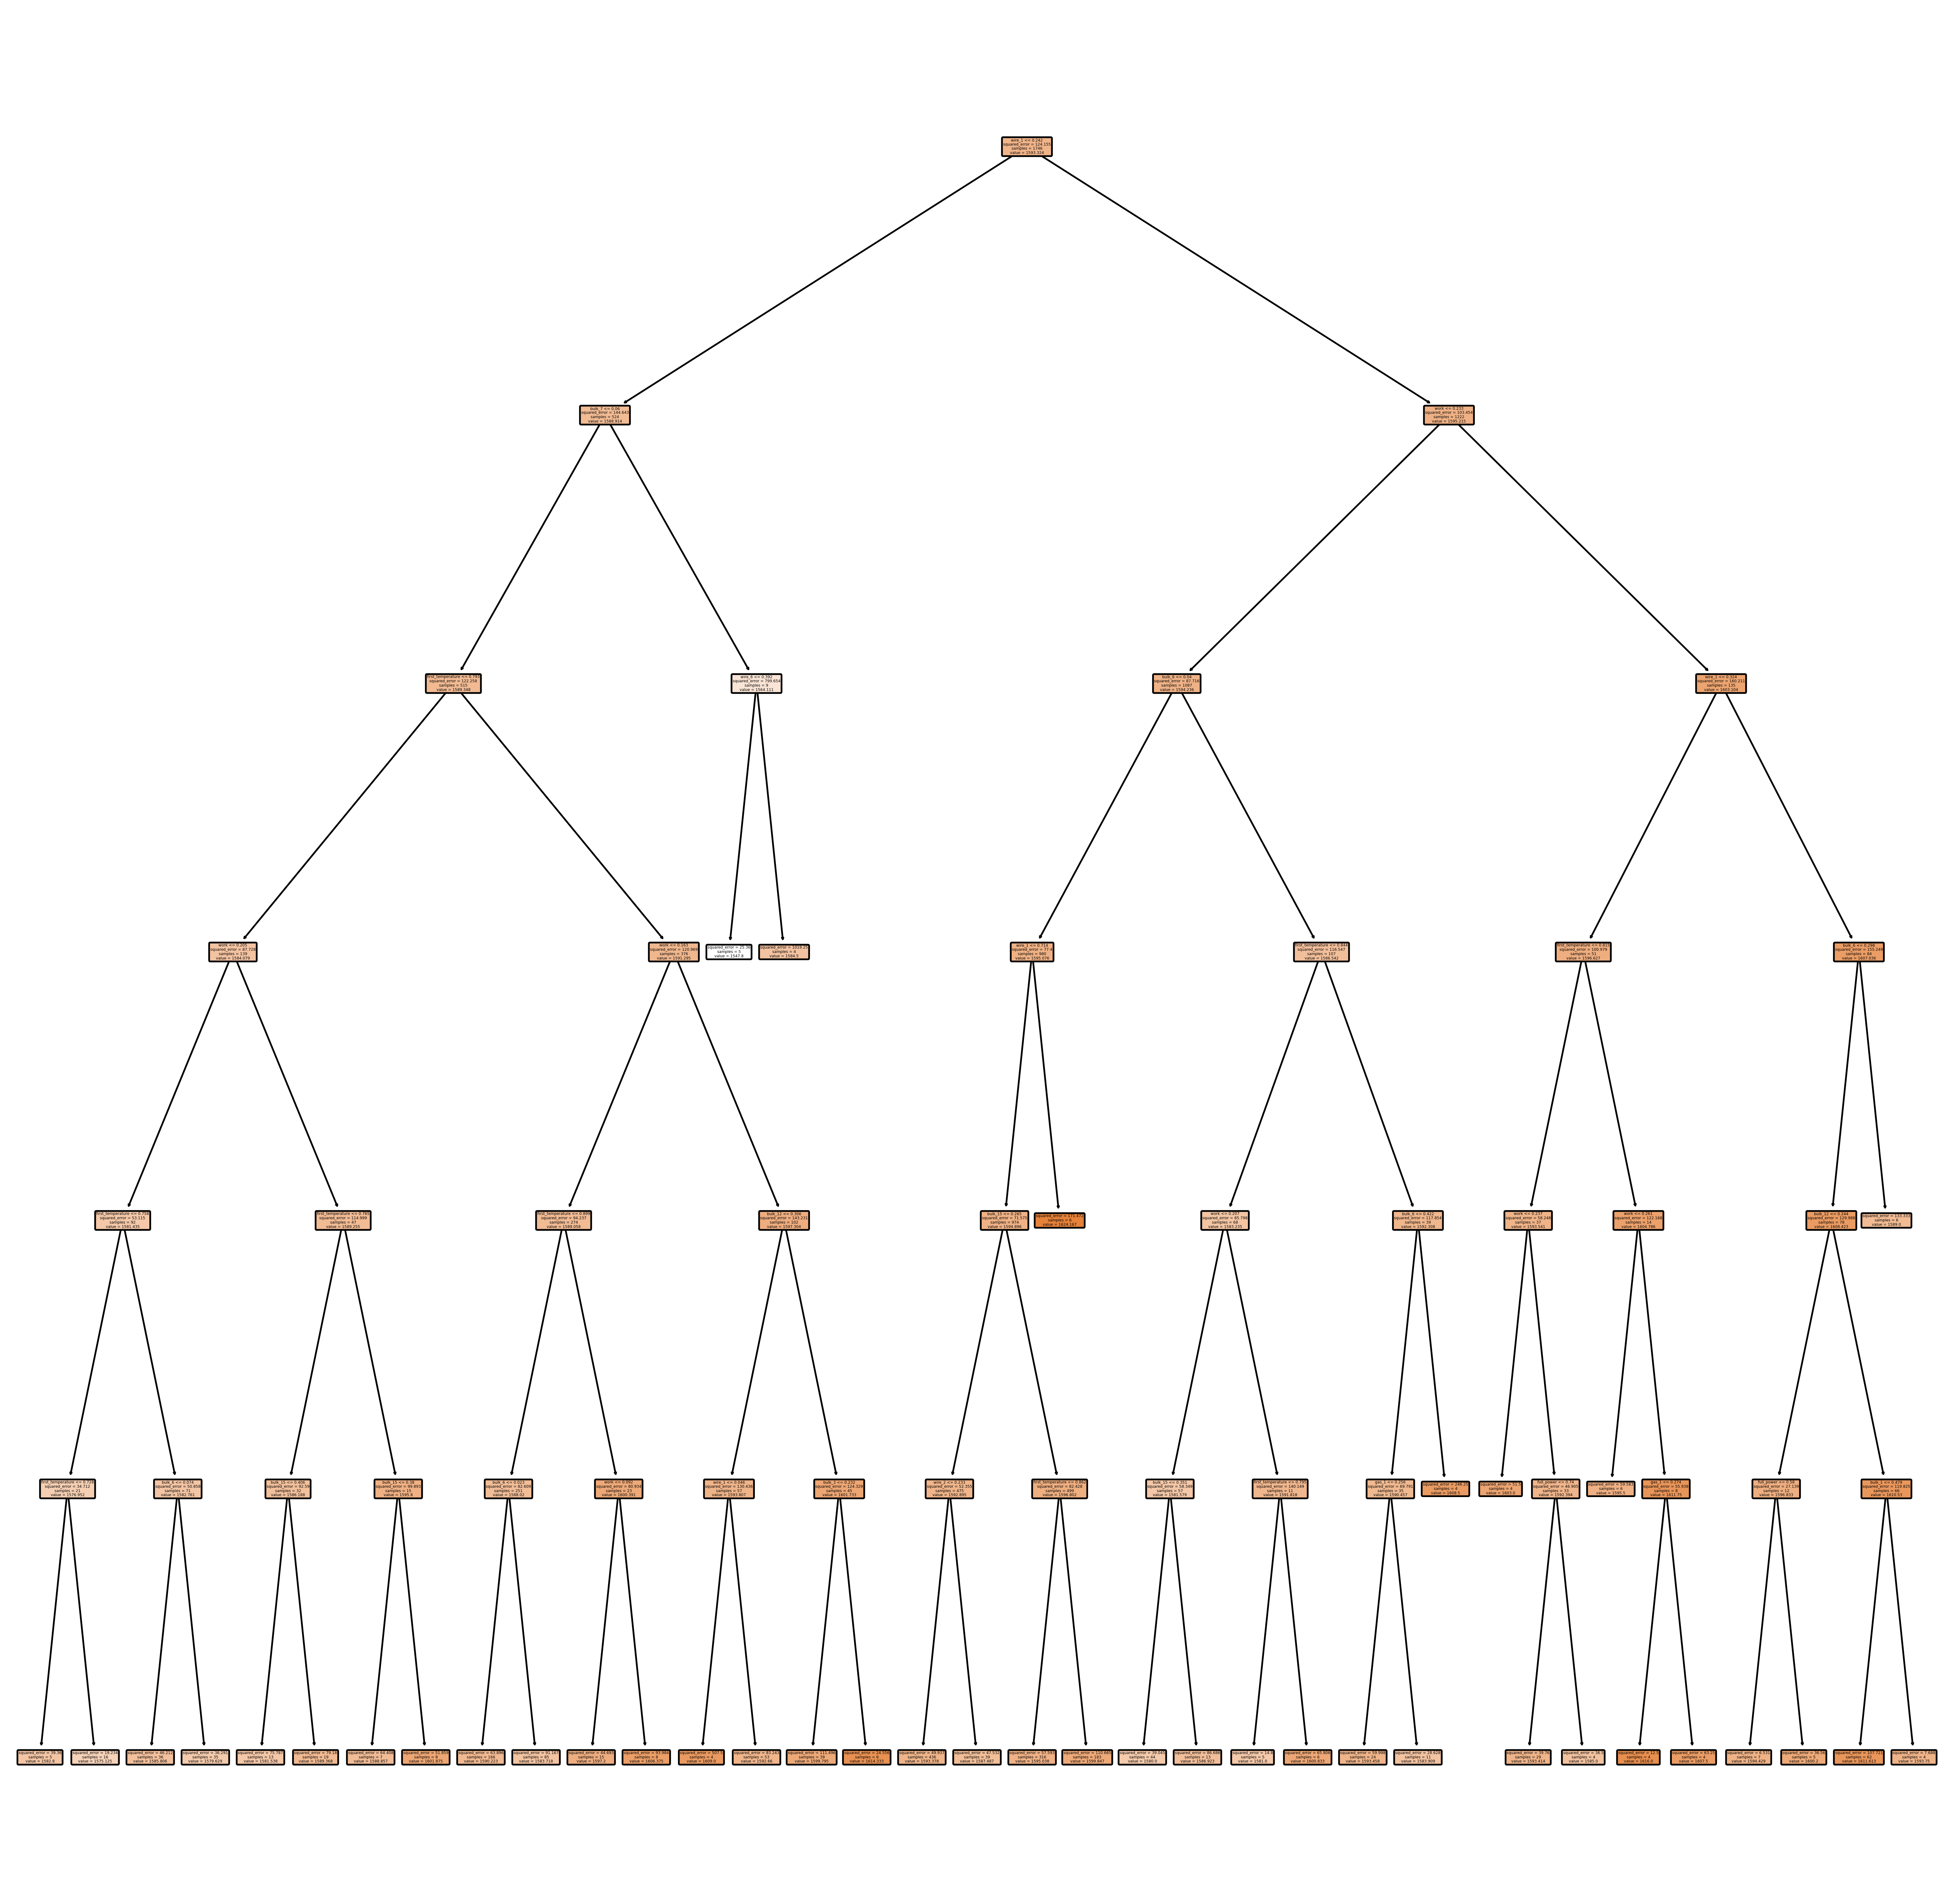

In [53]:
# Decision tree graph:

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 20), dpi=400)
plot_tree(tree_grid.best_estimator_, 
               feature_names=data_final.columns[:-1],
               class_names=True,
               filled=True, rounded=True)
plt.show()

### Random Forest

In [54]:
# setting up the model

forest = RandomForestRegressor(random_state=60623)
forest_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': range(1,11), 
    'min_samples_leaf': range(1,11)
}
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
forest_grid = GridSearchCV(forest, forest_params, scoring=mae_scorer, cv=5, n_jobs=-1)

# Training the model
forest_grid.fit(x_train, y_train)
forest_train_predictions = forest_grid.predict(x_train)

# MAE on training data:
forest_train_mae = mean_absolute_error(y_train, forest_train_predictions)
print('MAE of the Random Forest model on the training set:', forest_train_mae)

# MAE on cross-validation
forest_cv_mae = -forest_grid.best_score_
print('MAE of the Random Forest model on cross-validation:', forest_cv_mae)

# Displaying the best model parameters
print('Parameters of the best Random Forest model:', forest_grid.best_params_)

MAE of the Random Forest model on the training set: 4.1893359788277325
MAE of the Random Forest model on cross-validation: 6.513972849908858
Parameters of the best Random Forest model: {'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 100}


### Cat Boost

In [55]:
# setting up the model

cat_model = CatBoostRegressor(random_state=60623, verbose=False)
cat_param_grid = {
    'learning_rate': [0.03, 0.1],
    'depth': [4, 6, 10],
    'l2_leaf_reg': [1, 3, 9]
}
cat_grid = GridSearchCV(cat_model, cat_param_grid, cv=5, scoring='neg_mean_absolute_error')

# Training the model
cat_grid.fit(x_train, y_train)
cat_train_predictions = cat_grid.predict(x_train)

# MAE on training data
cat_train_mae = mean_absolute_error(y_train, cat_train_predictions)
print("MAE of the Cat Boost model on the training set: ", cat_train_mae)

# MAE on cross-validation
cat_cv_mae = -cat_grid.best_score_
print("MAE of the Cat Boost model on cross-validation: ", cat_cv_mae)

# Displaying the best model parameters
print('Parameters of the best Cat Boost model:', cat_grid.best_params_)

MAE of the Cat Boost model on the training set:  4.669244578162845
MAE of the Cat Boost model on cross-validation:  6.264014620691975
Parameters of the best Cat Boost model: {'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 0.03}


<b>Conclusions:</b>

Three models were chosen for training - Decision Tree, Random Forest, and CatBoost. The best model on cross-validation was CatBoost (MAE on cross-validation is 6.26). We will test it on the test set and compare it with the constant model.

## Testing the best model

### Testing the Cat Boost model

In [56]:
# checking the CatBoost model on the test set

cat_test_predictions = cat_grid.best_estimator_.predict(x_test)
cat_test_mae = mean_absolute_error(y_test, cat_test_predictions)
print('MAE of the CatBoost model on the test set:', cat_test_mae)

MAE of the CatBoost model on the test set: 6.175857086689246


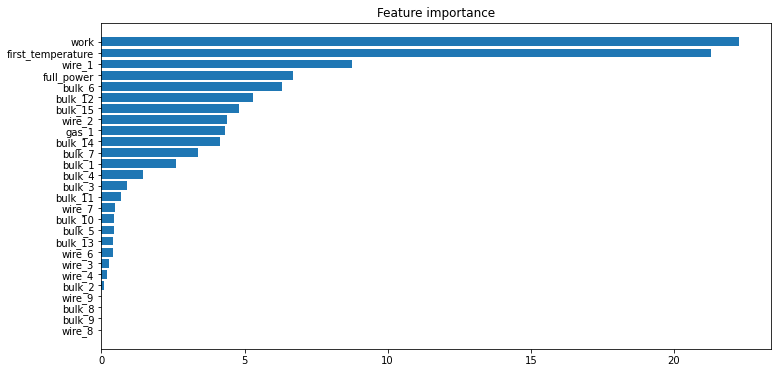

In [57]:
# determining feature importance

feature_importance = cat_grid.best_estimator_.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(data_final.columns[:-1])[sorted_idx])
plt.title('Feature importance')
plt.show()

### Model adequacy check

In [58]:
# creating a constant model

dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(x_train, y_train)
dummy_predictions = dummy_model.predict(x_test)
mae_dummy = mean_absolute_error(y_test, dummy_predictions)
print('MAE of the constant model on the test set:', mae_dummy)

MAE of the constant model on the test set: 8.356443594194673


<b>Conclusions</b>

On the test set, the Cat Boost's MAE result is 6.18 degrees, this result falls within the customer's target range. The model passed an adequacy check - the result is significantly better than the constant model.

## Final Report

### Business Understanding

#### Problem Definition

The aim of this project is to construct a model for a regression task that will predict the temperature of steel. 
<br>The dataset was obtained from the client - LLC "This is how we temper steel". The main task the client aims to solve is to reduce electricity consumption during the steel processing stage, which can be assisted by building a temperature prediction model. 
<br>The dataset description and a technical description of the alloy processing stages can be found at the link - https://concrete-web-bad.notion.site/85f2327a430b4c07ad9e0f3088ecf39c

#### Metrics

The quality metric for this project is the mean absolute error (MAE).
The metric should be obtained on a test sample after splitting the entire sample into training and testing sets.

### Data Collection and Usage

#### Initial Data

A total of 7 tables were presented for analysis:
1.	electrode data;
2.	data on the supply of bulk materials (volume);
3.	data on the supply of bulk materials (time);
4.	alloy gas blowing data;
5.	temperature measurement results;
6.	wire material data (volume);
7.	wire material data (time).

All files had a 'key' column containing the batch number. Electrode and temperature tables contained multiple rows with the same 'key' value, which corresponded to different processing iterations. In the other tables, the data was aggregated within each batch.

#### Data Processing

The following steps were taken in preparing the data for model training:
- Temporal data on the supply of bulk and wire materials were not selected as features for model training, thus no work was carried out with these tables.
- In the power table, batches with negative reactive power were removed (because the client stated this deviation was an anomaly). Power values were aggregated by mean, with added values for total power and heating time of each batch. These parameters will be used as features for model training.
- In the temperature table, all intermediate temperature values between the initial and final temperatures were removed. Batches were removed where there was only one temperature measurement, or where the initial or final temperature was unknown.
- Missing values in the tables with information on bulk materials and wires were replaced with 0, as it's likely that the missing values meant that no material was added.
- A final table was created, combining features for training and the target feature. A multicollinearity analysis was conducted.
- Final features for training are - full_power, work, bulk_1, bulk_2, bulk_3, bulk_4, bulk_5, bulk_6, bulk_7, bulk_8, bulk_9, bulk_10, bulk_11, bulk_12, bulk_13, bulk_14, bulk_15, wire_1, wire_2, wire_3, wire_4, wire_6, wire_7, wire_8, wire_9, gas_1, first_temperature. The target feature - final_temperature.

Numerical features were standardized using MinMaxScaler() due to the pronounced difference between minimum and maximum values.

#### Additional Findings

During the data handling, anomalies in the amount of gas supplied in some batches were discovered. Batches with gas supplies exceeding 40 were analyzed. Compared to the general sample, no significant differences in powers were identified, yet the heating duration was significantly longer. Furthermore, almost all medians of bulk materials and wire materials were identified specifically in batches with a large amount of gas. It's possible that these gas values are so high because large amounts of bulk materials or wire were used.

### Modeling

#### Model Training

Several models were selected for training - Decision Tree, Random Forest, and the CatBoost gradient boosting model. 
<br>Cross-validation was used during training. The CatBoost model proved to be the best on cross-validation (MAE on cross-validation was 6.26) with the following hyperparameters: depth - 4, l2_leaf_reg - 3, learning_rate - 0.03.

#### Model Testing

On the test sample, the CatBoost's MAE was 6.18 degrees, which falls within the client's target range. 
<br>The feature importance for the CatBoost model was analyzed, with the parameters "work" and "first_temperature" being chosen as the most significant features by the model.
<br>The model passed the adequacy check - its performance is significantly better than that of a constant model (a Dummy Regressor with a "mean" strategy was chosen as the constant model).

### Conclusion

Thus, the goal of this project - to build a regression model that will predict the steel temperature - has been achieved. It is advisable for the client to use our model for predicting alloy temperature and reducing electricity consumption during the steel processing stage.